In [1]:
import numpy as np
from numpy.random import randint, uniform, normal
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
import scipy.linalg as la
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from miniesn import *

# Set up static random reservoir

In [3]:
# Set up static random reservoir
Nhidden = 1500 # Number of hidden variables determine "memory" of reservoir

Nconnections    = 100 # Number of connections in sparse hidden-to-hidden matrix Whh
spectral_radius = 1.5 # Spectral radius of Whh

Wih = uniform(-1,1,(Nhidden,1)) # Random input-to-hidden matrix
bh  = uniform(-1,1,(Nhidden,1)) # Random bias term
Whh = sparse_esn_reservoir(Nhidden,Nconnections,spectral_radius) # Hidden-to-hidden recurrence

# Set up common training data for Test 1+2

In [4]:
# Set up data for training and prediction
Ntrans   = 500   # Number of transient initial steps before training
Ntrain   = 2500  # Number of steps to train on
Npredict = 500   # Number of steps for free-running prediction
xs       = np.linspace(0,30*2*np.pi,Ntrain+Npredict)
sins     = np.array([np.sin(j*xs) for j in range(8)])

# Data sets 1 and 2: 
data1 = sins[1] # Level 1: Simple sine curve
data2 = sins[1]+2*sins[2]+sins[3]+sins[5]+2*sins[7] # Level 2: More complicated periodic function
data2 /= np.abs(data2).max() # Math is set up to work on data normalized to [-1,1]

# Test 1: Predicting a simple sine curve

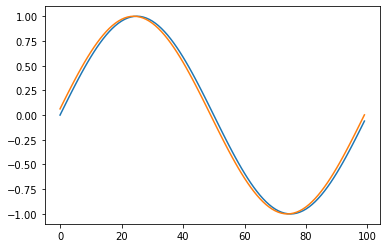

In [5]:
#------- Test 1: Predicting a simple sine curve -----
data = data1;

# First we split the data into training data (input/labels) and prediction labels
# (To verify that our prediction is correct)
inputs, labels, pred_labels = split_train_label_pred(data,Ntrain,Npredict)

#Let's look at the first 100 elements of inputs and labels (outputs):
#
# In training, the label in step i becomes the input of step i+1, to simulate
# using the ith output as input to step i+1. So, the training input is just 
# the training labels shifted by one step.
# When we do the free-running prediction, we will instead feed the calculated 
# output back in as input.
plt.plot(inputs[:100])
plt.plot(labels[:100])

In [6]:
# Second, we initialize the hidden state sequence from the input sequence
H = generate_state_matrix((Whh,Wih,bh),inputs,Ntrans)

In [7]:
# From this, we can do a simple least-squares fit to find the hidden-to-output
# matrix Woh. Other criteria can be built in to the fit, such as 
# Tikhonov-regularization to avoid over-fitting, or other constraints.
Who = lstsq_stable(H,labels[Ntrans:Ntrain])

In [8]:
# Our trained model now simply consists of the static matrices 
# Whh (hidden-hidden), Wih (input-hidden), and bh (bias hidden), which
# are problem-independent and are unrelated to the data, and the learned
# hidden-to-output matrix Who.
model = (Whh,Wih,bh,Who)

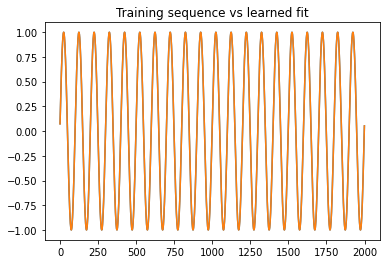

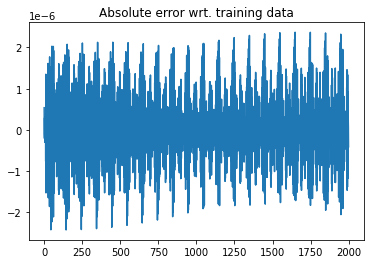

In [9]:
# First, we check: how well did our model predict the past? (How 
# well did we manage to fit the training data)

plt.title("Training sequence vs learned fit")
plt.plot(Who.dot(H.T))
plt.plot(labels[Ntrans:Ntrain])
plt.show()

plt.title("Absolute error wrt. training data")

plt.plot(Who.dot(H.T)-labels[Ntrans:Ntrain])
plt.show()

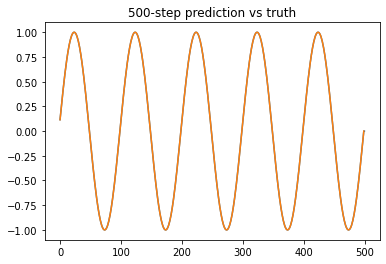

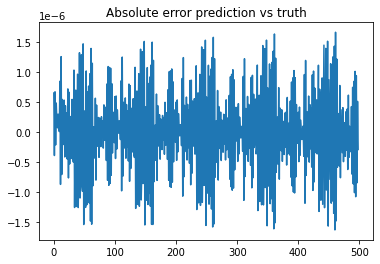

In [10]:
# All right, looks pretty good! Maximum error of about 0.00001 in the training set.
# We finally validate by checking if we can predict 500 steps into the future:
state0 = H[-1]
input0 = labels[-1]

# Predict Npredict steps into the future, running free from final
# training input and hidden state.
ys, h = predict(model,state0,input0,Npredict)

# Let's compare the 500-step forecast with the true continuation of the sequence
plt.plot(ys)
plt.plot(pred_labels)
plt.title("500-step prediction vs truth")
plt.show()

plt.plot(ys[:-1]-pred_labels)
plt.title("Absolute error prediction vs truth")
plt.show()

In [11]:
# Not bad! 
# Visually indistinguishable even after 500 free-predicting steps, and 5-6 digit accuracy.

# Test 2: Predicting a complicated periodic function

In [12]:
#------- Test 2: Predicting a complicated periodic function -----
#
# Now let's try something more complicated, but still
# very predictable: A periodic function composed of a handful 
# of frequencies: 
data = data2;

# First we split the data into training data (input/labels) and prediction labels
# (To verify that our prediction is correct)
inputs, labels, pred_labels = split_train_label_pred(data,Ntrain,Npredict)

# Second, we initialize the hidden state sequence from the input sequence
H = generate_state_matrix((Whh,Wih,bh),inputs,Ntrans)

# Third, we can find the hidden-to-output matrix Woh with a linear
# least-squares fit.
Who = lstsq_stable(H,labels[Ntrans:Ntrain])

# Our trained model now simply consists of the static matrices 
# Whh (hidden-hidden), Wih (input-hidden), and bh (bias hidden), which
# are problem-independent and are unrelated to the data, and the learned
# hidden-to-output matrix Who.
model = (Whh,Wih,bh,Who)

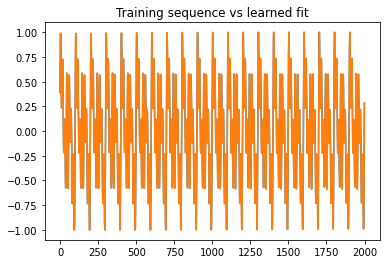

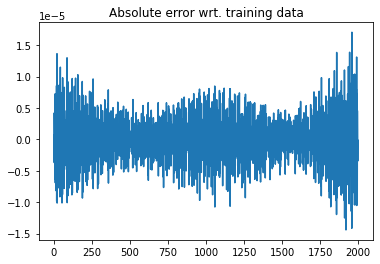

In [13]:
# First, we check: how well did our model predict the past? (How 
# well did we manage to fit the training data)

plt.title("Training sequence vs learned fit")
plt.plot(Who.dot(H.T))
plt.plot(labels[Ntrans:Ntrain])
plt.show()

plt.title("Absolute error wrt. training data")
plt.plot(Who.dot(H.T)-labels[Ntrans:Ntrain])
plt.show()

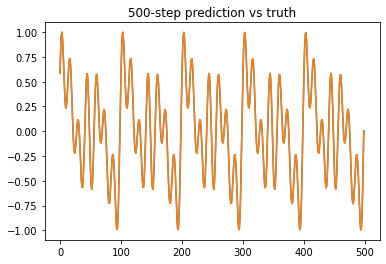

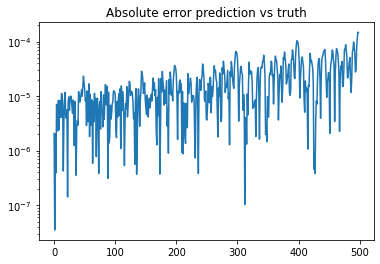

In [14]:
# We finally use the trained model to do a free-running prediction for 500 
# steps into the future, and check against the validation data pred_labels.
state0 = H[-1]
input0 = labels[-1]


# Predict Npredict steps into the future, running free from final
# training input and hidden state.
ys, h = predict(model,state0,input0,Npredict)

# Let's compare the 500-step forecast with the true continuation of the sequence
plt.plot(ys)
plt.plot(pred_labels)
plt.title("500-step prediction vs truth")
plt.show()

plt.semilogy(np.abs(ys[:-1]-pred_labels))
plt.title("Absolute error prediction vs truth")
plt.show()

In [ ]:
# We see that the prediction is visually indistinguishable from the validation data,
# with errors only on the third digit.

# Test 3: Predicting a chaotic sequence 

In [16]:
#------- Test 3: Predicting a chaotic sequence -----
#
# Our final test is to predict the Mackey-Glass sequence 
# (http://www.scholarpedia.org/article/Mackey-Glass_equation)

def mackey_sequence(b=None, N=3000):
    """Create the Mackey-Glass series"""
    c = 0.2
    tau = 17
    n = 10

    yinit = np.array([0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076,
        1.1352, 1.1485, 1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756,
        1.0739, 1.0759])

    if b is None:
        b = np.zeros(N) + 0.1

    y = np.zeros(N)
    y[:yinit.shape[0]] = yinit

    for i in range(tau, N - 1):
        yi = y[i] - b[i] * y[i] + c * y[i - tau] / (1 + y[i - tau]**n)
        y[i + 1] = yi
    return y




In [17]:
# Training data for task 3
data = mackey_sequence()

# 1. Split into training and validation
inputs, labels, pred_labels = split_train_label_pred(data,Ntrain,Npredict)

# 2. Initialize the hidden state sequence from the input sequence
H = generate_state_matrix((Whh,Wih,bh),inputs,Ntrans)

# 3. Find the hidden-to-output matrix Woh 
Who = lstsq_stable(H,labels[Ntrans:Ntrain])

model = (Whh,Wih,bh,Who)

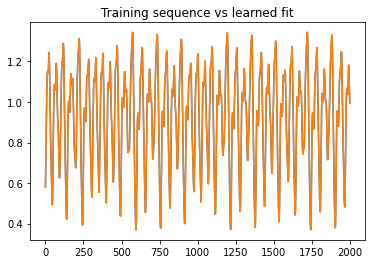

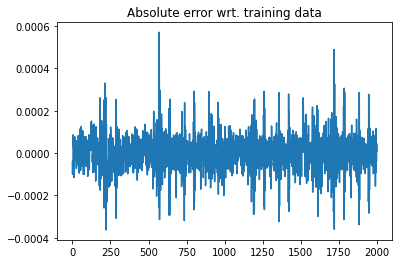

In [18]:
# How well did our model predict the past? 
# (How  well did we manage to fit the training data)
plt.plot(Who.dot(H.T))
plt.plot(labels[Ntrans:Ntrain])
plt.title("Training sequence vs learned fit")
plt.show()
# We see no visual difference.

plt.plot(Who.dot(H.T)-labels[Ntrans:Ntrain])
plt.title("Absolute error wrt. training data")
plt.show()

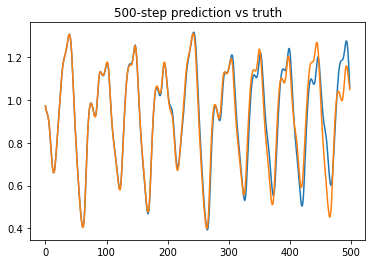

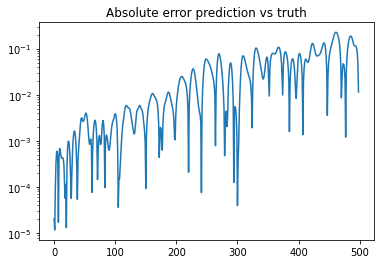

In [19]:
# We again use the trained model to do a free-running prediction for 500 
# steps into the future, and check against the validation data pred_labels.
state0 = H[-1]
input0 = labels[-1]

# Predict Npredict steps into the future, running free from final
# training input and hidden state.
ys, h = predict(model,state0,input0,Npredict)

# Let's compare the 500-step forecast with the true continuation of the sequence
plt.plot(ys[:-1])
plt.plot(pred_labels)
plt.title("500-step prediction vs truth")
plt.show()

plt.title("Absolute error prediction vs truth")
plt.semilogy(np.abs(ys[:-1]-pred_labels))
plt.show()